# **Dependancies**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import *
from keras.callbacks import *
import os
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from keras.layers import *
from sklearn.pipeline import Pipeline

2022-12-04 15:40:36.867982: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# **Loading Data**

In [3]:
selected = pd.read_csv("../Data/train_btc_selected_features.csv")
btc = pd.read_csv("../Data/btc_Data.csv")
btc['Date'] = pd.to_datetime(btc['Date'])
btc = btc.set_index("Date")

In [4]:
btcData = btc[selected.columns]
btcData['returns'] = btcData['priceUSD'].pct_change().copy()
Data = btcData.drop(columns=['priceUSD'])
Data = Data[1:]
# divide X and Y
X = Data.iloc[:,0:]
#Y = Data['returns']   # 用returns的话就用这一行，然后把下一行comment掉
Y = btcData['priceUSD'].shift(-30)[1:] # 反之亦然
# Split into three data sets
X_train = X['2016-01-01':'2019-12-31']
X_val = X['2020-01-01':'2021-05-31']
X_test = X['2021-06-01':'2023-01-01']

Y_train = Y['2016-01-01':'2019-12-31']
Y_val = Y['2020-01-01':'2021-05-31']
Y_test = Y['2021-06-01':'2023-01-01']

/tmp/ipykernel_2899128/3854812091.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btcData['returns'] = btcData['priceUSD'].pct_change().copy()


In [5]:
estimators=[]
estimators.append(['mixmax',MinMaxScaler()])
estimators.append(['robust',RobustScaler()])
scale=Pipeline(estimators,verbose=True)
scale.fit(X_train)
X_train=scale.transform(X_train)
X_test=scale.transform(X_test)
X_val = scale.transform(X_val)
tmp_index = Y_test.index

[Pipeline] ............ (step 1 of 2) Processing mixmax, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing robust, total=   0.0s


In [6]:
X_train=np.reshape(X_train,(X_train.shape[0],1,X_train.shape[1]))
X_val=np.reshape(X_val,(X_val.shape[0],1,X_val.shape[1]))
X_test=np.reshape(X_test,(X_test.shape[0],1,X_test.shape[1]))
Y_train=Y_train.values
Y_train=np.reshape(Y_train, (Y_train.shape[0],1,1))
Y_val=Y_val.values
Y_val=np.reshape(Y_val, (Y_val.shape[0],1,1))
Y_test=Y_test.values
Y_test=np.reshape(Y_test, (Y_test.shape[0],1,1))

In [7]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [8]:
adam=optimizers.Adam(lr=lr_schedule(0),amsgrad=True)


Learning rate:  0.001


/home/spectre/anaconda3/envs/tensorplustorch/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


# https://medium.com/analytics-vidhya/hypertuning-a-lstm-with-keras-tuner-to-forecast-solar-irradiance-7da7577e96eb

In [9]:
regressor = Sequential()
regressor.add(Bidirectional(LSTM(350, return_sequences=True, activation='relu'), input_shape=(1, X_train.shape[2])))
regressor.add(Bidirectional(LSTM(350, return_sequences=True, activation='relu')))
regressor.add(Dense(1))
regressor.compile(loss="logcosh", optimizer=adam, metrics=['mae'])

2022-12-04 15:40:38.123040: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-04 15:40:38.124107: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [10]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=1000, verbose=1, mode='auto')

In [11]:
regressor.fit(X_train,Y_train, epochs=5000, batch_size=32, validation_data=(X_val,Y_val), callbacks=[earlyStopping])

Epoch 1/5000
46/46 [==============================] - 4s 45ms/step - loss: 4761.9102 - mae: 4762.6025 - val_loss: 19223.4375 - val_mae: 19224.1309
Epoch 2/5000
46/46 [==============================] - 2s 41ms/step - loss: 3436.6812 - mae: 3437.3745 - val_loss: 6741.5103 - val_mae: 6742.2036
Epoch 3/5000
46/46 [==============================] - 2s 39ms/step - loss: 2029.5686 - mae: 2030.2611 - val_loss: 6016.0298 - val_mae: 6016.7231
Epoch 4/5000
46/46 [==============================] - 2s 33ms/step - loss: 1599.3231 - mae: 1600.0159 - val_loss: 6294.9976 - val_mae: 6295.6899
Epoch 5/5000
46/46 [==============================] - 2s 34ms/step - loss: 1308.4103 - mae: 1309.1031 - val_loss: 6447.3574 - val_mae: 6448.0503
Epoch 6/5000
46/46 [==============================] - 2s 46ms/step - loss: 1172.9850 - mae: 1173.6772 - val_loss: 6705.4082 - val_mae: 6706.1011
Epoch 7/5000
46/46 [==============================] - 2s 37ms/step - loss: 1077.5599 - mae: 1078.2521 - val_loss: 6746.4648 - va

Epoch 58/5000
46/46 [==============================] - 2s 35ms/step - loss: 317.8030 - mae: 318.4928 - val_loss: 8477.8115 - val_mae: 8478.5049
Epoch 59/5000
46/46 [==============================] - 2s 38ms/step - loss: 329.1577 - mae: 329.8482 - val_loss: 8591.9971 - val_mae: 8592.6904
Epoch 60/5000
46/46 [==============================] - 2s 35ms/step - loss: 329.9289 - mae: 330.6205 - val_loss: 8517.5518 - val_mae: 8518.2461
Epoch 61/5000
46/46 [==============================] - 2s 38ms/step - loss: 315.9620 - mae: 316.6522 - val_loss: 8645.0439 - val_mae: 8645.7363
Epoch 62/5000
46/46 [==============================] - 2s 45ms/step - loss: 316.9644 - mae: 317.6551 - val_loss: 8230.3887 - val_mae: 8231.0820
Epoch 63/5000
46/46 [==============================] - 2s 36ms/step - loss: 304.6367 - mae: 305.3261 - val_loss: 8482.8174 - val_mae: 8483.5107
Epoch 64/5000
46/46 [==============================] - 2s 39ms/step - loss: 295.0815 - mae: 295.7715 - val_loss: 8520.3418 - val_mae: 85

Epoch 115/5000
46/46 [==============================] - 2s 36ms/step - loss: 195.2096 - mae: 195.8991 - val_loss: 9780.7510 - val_mae: 9781.4453
Epoch 116/5000
46/46 [==============================] - 2s 43ms/step - loss: 200.8238 - mae: 201.5137 - val_loss: 9599.7041 - val_mae: 9600.3975
Epoch 117/5000
46/46 [==============================] - 2s 44ms/step - loss: 194.6975 - mae: 195.3839 - val_loss: 9530.5342 - val_mae: 9531.2275
Epoch 118/5000
46/46 [==============================] - 2s 38ms/step - loss: 190.0944 - mae: 190.7831 - val_loss: 9412.7539 - val_mae: 9413.4473
Epoch 119/5000
46/46 [==============================] - 2s 39ms/step - loss: 194.4309 - mae: 195.1187 - val_loss: 9593.9326 - val_mae: 9594.6260
Epoch 120/5000
46/46 [==============================] - 2s 43ms/step - loss: 185.8822 - mae: 186.5707 - val_loss: 9686.0713 - val_mae: 9686.7646
Epoch 121/5000
46/46 [==============================] - 2s 51ms/step - loss: 188.1131 - mae: 188.8006 - val_loss: 9747.0381 - val_

46/46 [==============================] - 2s 39ms/step - loss: 143.4708 - mae: 144.1591 - val_loss: 9475.4697 - val_mae: 9476.1641
Epoch 172/5000
46/46 [==============================] - 2s 36ms/step - loss: 146.4708 - mae: 147.1570 - val_loss: 9270.6494 - val_mae: 9271.3428
Epoch 173/5000
46/46 [==============================] - 2s 40ms/step - loss: 148.9255 - mae: 149.6096 - val_loss: 9220.2578 - val_mae: 9220.9502
Epoch 174/5000
46/46 [==============================] - 2s 36ms/step - loss: 155.3364 - mae: 156.0237 - val_loss: 9289.5586 - val_mae: 9290.2510
Epoch 175/5000
46/46 [==============================] - 2s 37ms/step - loss: 141.5325 - mae: 142.2188 - val_loss: 9449.6729 - val_mae: 9450.3662
Epoch 176/5000
46/46 [==============================] - 2s 37ms/step - loss: 141.3732 - mae: 142.0574 - val_loss: 9400.7480 - val_mae: 9401.4414
Epoch 177/5000
46/46 [==============================] - 2s 46ms/step - loss: 136.4855 - mae: 137.1705 - val_loss: 9079.1543 - val_mae: 9079.8496


46/46 [==============================] - 2s 37ms/step - loss: 117.3982 - mae: 118.0833 - val_loss: 9202.9805 - val_mae: 9203.6738
Epoch 228/5000
46/46 [==============================] - 2s 36ms/step - loss: 125.1335 - mae: 125.8199 - val_loss: 8987.9033 - val_mae: 8988.5967
Epoch 229/5000
46/46 [==============================] - 2s 36ms/step - loss: 116.0978 - mae: 116.7858 - val_loss: 9092.6172 - val_mae: 9093.3096
Epoch 230/5000
46/46 [==============================] - 2s 40ms/step - loss: 124.2226 - mae: 124.9086 - val_loss: 9185.0605 - val_mae: 9185.7539
Epoch 231/5000
46/46 [==============================] - 2s 47ms/step - loss: 123.3172 - mae: 124.0042 - val_loss: 9226.4170 - val_mae: 9227.1104
Epoch 232/5000
46/46 [==============================] - 2s 41ms/step - loss: 124.0046 - mae: 124.6924 - val_loss: 8942.5039 - val_mae: 8943.1973
Epoch 233/5000
46/46 [==============================] - 2s 36ms/step - loss: 120.9621 - mae: 121.6477 - val_loss: 9236.3486 - val_mae: 9237.0420


46/46 [==============================] - 2s 41ms/step - loss: 105.0236 - mae: 105.7095 - val_loss: 8973.6826 - val_mae: 8974.3750
Epoch 284/5000
46/46 [==============================] - 2s 49ms/step - loss: 103.5832 - mae: 104.2669 - val_loss: 9026.8750 - val_mae: 9027.5684
Epoch 285/5000
46/46 [==============================] - 2s 48ms/step - loss: 102.8287 - mae: 103.5135 - val_loss: 9063.1504 - val_mae: 9063.8447
Epoch 286/5000
46/46 [==============================] - 2s 39ms/step - loss: 107.6147 - mae: 108.2983 - val_loss: 9115.6611 - val_mae: 9116.3545
Epoch 287/5000
46/46 [==============================] - 2s 37ms/step - loss: 106.7025 - mae: 107.3906 - val_loss: 9135.1260 - val_mae: 9135.8193
Epoch 288/5000
46/46 [==============================] - 2s 37ms/step - loss: 108.9613 - mae: 109.6464 - val_loss: 9132.9307 - val_mae: 9133.6240
Epoch 289/5000
46/46 [==============================] - 2s 37ms/step - loss: 104.8743 - mae: 105.5598 - val_loss: 9179.3682 - val_mae: 9180.0596


Epoch 340/5000
46/46 [==============================] - 2s 41ms/step - loss: 96.5130 - mae: 97.1966 - val_loss: 8995.8232 - val_mae: 8996.5166
Epoch 341/5000
46/46 [==============================] - 2s 35ms/step - loss: 100.3922 - mae: 101.0768 - val_loss: 9199.4307 - val_mae: 9200.1230
Epoch 342/5000
46/46 [==============================] - 2s 37ms/step - loss: 102.2356 - mae: 102.9208 - val_loss: 9055.5791 - val_mae: 9056.2725
Epoch 343/5000
46/46 [==============================] - 2s 43ms/step - loss: 95.8187 - mae: 96.5023 - val_loss: 9251.6162 - val_mae: 9252.3086
Epoch 344/5000
46/46 [==============================] - 2s 44ms/step - loss: 99.4788 - mae: 100.1634 - val_loss: 9213.2979 - val_mae: 9213.9922
Epoch 345/5000
46/46 [==============================] - 2s 48ms/step - loss: 95.1304 - mae: 95.8130 - val_loss: 9121.9580 - val_mae: 9122.6504
Epoch 346/5000
46/46 [==============================] - 2s 40ms/step - loss: 104.8933 - mae: 105.5795 - val_loss: 9088.0020 - val_mae: 90

46/46 [==============================] - 2s 40ms/step - loss: 94.9661 - mae: 95.6475 - val_loss: 9121.8555 - val_mae: 9122.5498
Epoch 398/5000
46/46 [==============================] - 2s 34ms/step - loss: 97.2529 - mae: 97.9395 - val_loss: 9025.5508 - val_mae: 9026.2441
Epoch 399/5000
46/46 [==============================] - 2s 36ms/step - loss: 91.2062 - mae: 91.8901 - val_loss: 9096.3760 - val_mae: 9097.0674
Epoch 400/5000
46/46 [==============================] - 2s 36ms/step - loss: 85.2413 - mae: 85.9253 - val_loss: 9117.8613 - val_mae: 9118.5557
Epoch 401/5000
46/46 [==============================] - 2s 43ms/step - loss: 94.0473 - mae: 94.7325 - val_loss: 9069.7725 - val_mae: 9070.4648
Epoch 402/5000
46/46 [==============================] - 2s 49ms/step - loss: 99.4139 - mae: 100.0976 - val_loss: 9219.1201 - val_mae: 9219.8125
Epoch 403/5000
46/46 [==============================] - 2s 38ms/step - loss: 99.1010 - mae: 99.7849 - val_loss: 9094.5625 - val_mae: 9095.2559
Epoch 404/500

46/46 [==============================] - 2s 39ms/step - loss: 80.8788 - mae: 81.5624 - val_loss: 9212.1777 - val_mae: 9212.8711
Epoch 455/5000
46/46 [==============================] - 2s 46ms/step - loss: 82.0221 - mae: 82.7034 - val_loss: 8995.4980 - val_mae: 8996.1904
Epoch 456/5000
46/46 [==============================] - 2s 37ms/step - loss: 82.8868 - mae: 83.5671 - val_loss: 8943.5039 - val_mae: 8944.1963
Epoch 457/5000
46/46 [==============================] - 2s 45ms/step - loss: 88.3188 - mae: 89.0034 - val_loss: 9093.0186 - val_mae: 9093.7119
Epoch 458/5000
46/46 [==============================] - 2s 49ms/step - loss: 84.7278 - mae: 85.4123 - val_loss: 9076.7695 - val_mae: 9077.4629
Epoch 459/5000
46/46 [==============================] - 2s 44ms/step - loss: 85.3819 - mae: 86.0662 - val_loss: 8925.9131 - val_mae: 8926.6064
Epoch 460/5000
46/46 [==============================] - 2s 37ms/step - loss: 82.9706 - mae: 83.6513 - val_loss: 9086.2383 - val_mae: 9086.9326
Epoch 461/5000

46/46 [==============================] - 2s 39ms/step - loss: 76.7209 - mae: 77.4031 - val_loss: 8997.9365 - val_mae: 8998.6289
Epoch 512/5000
46/46 [==============================] - 2s 46ms/step - loss: 79.4598 - mae: 80.1420 - val_loss: 9019.6865 - val_mae: 9020.3799
Epoch 513/5000
46/46 [==============================] - 2s 42ms/step - loss: 78.7575 - mae: 79.4404 - val_loss: 8874.3027 - val_mae: 8874.9951
Epoch 514/5000
46/46 [==============================] - 2s 46ms/step - loss: 78.2857 - mae: 78.9702 - val_loss: 9015.1494 - val_mae: 9015.8418
Epoch 515/5000
46/46 [==============================] - 2s 49ms/step - loss: 74.6112 - mae: 75.2913 - val_loss: 9073.6787 - val_mae: 9074.3721
Epoch 516/5000
46/46 [==============================] - 2s 52ms/step - loss: 74.8911 - mae: 75.5730 - val_loss: 9098.1094 - val_mae: 9098.8027
Epoch 517/5000
46/46 [==============================] - 2s 47ms/step - loss: 77.4988 - mae: 78.1790 - val_loss: 8928.5342 - val_mae: 8929.2275
Epoch 518/5000

46/46 [==============================] - 2s 52ms/step - loss: 82.8026 - mae: 83.4858 - val_loss: 8869.9268 - val_mae: 8870.6191
Epoch 569/5000
46/46 [==============================] - 2s 52ms/step - loss: 77.9620 - mae: 78.6426 - val_loss: 8943.5098 - val_mae: 8944.2012
Epoch 570/5000
46/46 [==============================] - 3s 54ms/step - loss: 73.2167 - mae: 73.8965 - val_loss: 8958.0605 - val_mae: 8958.7529
Epoch 571/5000
46/46 [==============================] - 2s 44ms/step - loss: 78.4032 - mae: 79.0887 - val_loss: 8915.8496 - val_mae: 8916.5430
Epoch 572/5000
46/46 [==============================] - 2s 41ms/step - loss: 79.8994 - mae: 80.5796 - val_loss: 9179.6016 - val_mae: 9180.2939
Epoch 573/5000
46/46 [==============================] - 2s 45ms/step - loss: 77.2684 - mae: 77.9456 - val_loss: 8945.4775 - val_mae: 8946.1719
Epoch 574/5000
46/46 [==============================] - 2s 50ms/step - loss: 78.2203 - mae: 78.9039 - val_loss: 8899.2031 - val_mae: 8899.8965
Epoch 575/5000

46/46 [==============================] - 3s 55ms/step - loss: 70.8093 - mae: 71.4873 - val_loss: 8945.5059 - val_mae: 8946.2002
Epoch 626/5000
46/46 [==============================] - 3s 55ms/step - loss: 70.2023 - mae: 70.8863 - val_loss: 8870.9043 - val_mae: 8871.5977
Epoch 627/5000
46/46 [==============================] - 2s 43ms/step - loss: 68.9769 - mae: 69.6566 - val_loss: 8917.0166 - val_mae: 8917.7090
Epoch 628/5000
46/46 [==============================] - 3s 57ms/step - loss: 64.9102 - mae: 65.5900 - val_loss: 8826.7871 - val_mae: 8827.4805
Epoch 629/5000
46/46 [==============================] - 2s 49ms/step - loss: 68.5895 - mae: 69.2677 - val_loss: 8935.3232 - val_mae: 8936.0156
Epoch 630/5000
46/46 [==============================] - 2s 48ms/step - loss: 73.3362 - mae: 74.0185 - val_loss: 8914.0889 - val_mae: 8914.7812
Epoch 631/5000
46/46 [==============================] - 3s 55ms/step - loss: 68.8484 - mae: 69.5281 - val_loss: 9004.8135 - val_mae: 9005.5078
Epoch 632/5000

46/46 [==============================] - 3s 59ms/step - loss: 66.3698 - mae: 67.0459 - val_loss: 8955.7266 - val_mae: 8956.4199
Epoch 683/5000
46/46 [==============================] - 2s 47ms/step - loss: 68.0837 - mae: 68.7582 - val_loss: 8832.5459 - val_mae: 8833.2363
Epoch 684/5000
46/46 [==============================] - 2s 39ms/step - loss: 68.9460 - mae: 69.6250 - val_loss: 8971.7920 - val_mae: 8972.4844
Epoch 685/5000
46/46 [==============================] - 2s 44ms/step - loss: 63.0134 - mae: 63.6918 - val_loss: 8832.6309 - val_mae: 8833.3232
Epoch 686/5000
46/46 [==============================] - 2s 42ms/step - loss: 61.4609 - mae: 62.1369 - val_loss: 8847.8105 - val_mae: 8848.5020
Epoch 687/5000
46/46 [==============================] - 2s 45ms/step - loss: 62.5152 - mae: 63.1972 - val_loss: 8888.1777 - val_mae: 8888.8701
Epoch 688/5000
46/46 [==============================] - 2s 54ms/step - loss: 69.6524 - mae: 70.3323 - val_loss: 8966.7324 - val_mae: 8967.4248
Epoch 689/5000

46/46 [==============================] - 2s 54ms/step - loss: 66.6329 - mae: 67.3115 - val_loss: 8956.5469 - val_mae: 8957.2393
Epoch 740/5000
46/46 [==============================] - 3s 61ms/step - loss: 63.6259 - mae: 64.3037 - val_loss: 8976.2461 - val_mae: 8976.9395
Epoch 741/5000
46/46 [==============================] - 2s 50ms/step - loss: 72.7244 - mae: 73.4039 - val_loss: 8835.1504 - val_mae: 8835.8438
Epoch 742/5000
46/46 [==============================] - 2s 43ms/step - loss: 57.5095 - mae: 58.1881 - val_loss: 8968.2119 - val_mae: 8968.9053
Epoch 743/5000
46/46 [==============================] - 2s 49ms/step - loss: 63.3013 - mae: 63.9810 - val_loss: 8900.6357 - val_mae: 8901.3291
Epoch 744/5000
46/46 [==============================] - 2s 53ms/step - loss: 64.5013 - mae: 65.1796 - val_loss: 8775.4785 - val_mae: 8776.1719
Epoch 745/5000
46/46 [==============================] - 2s 45ms/step - loss: 58.7780 - mae: 59.4565 - val_loss: 8924.9170 - val_mae: 8925.6104
Epoch 746/5000

46/46 [==============================] - 2s 48ms/step - loss: 64.2785 - mae: 64.9577 - val_loss: 8866.9648 - val_mae: 8867.6582
Epoch 797/5000
46/46 [==============================] - 2s 43ms/step - loss: 59.3613 - mae: 60.0397 - val_loss: 8912.0391 - val_mae: 8912.7324
Epoch 798/5000
46/46 [==============================] - 2s 40ms/step - loss: 56.9956 - mae: 57.6771 - val_loss: 8836.0498 - val_mae: 8836.7441
Epoch 799/5000
46/46 [==============================] - 1s 30ms/step - loss: 58.8872 - mae: 59.5643 - val_loss: 8977.8418 - val_mae: 8978.5332
Epoch 800/5000
46/46 [==============================] - 2s 41ms/step - loss: 56.0318 - mae: 56.7081 - val_loss: 8944.1670 - val_mae: 8944.8604
Epoch 801/5000
46/46 [==============================] - 3s 57ms/step - loss: 58.4192 - mae: 59.0967 - val_loss: 8983.8701 - val_mae: 8984.5645
Epoch 802/5000
46/46 [==============================] - 2s 39ms/step - loss: 63.2317 - mae: 63.9072 - val_loss: 8833.6230 - val_mae: 8834.3154
Epoch 803/5000

46/46 [==============================] - 2s 33ms/step - loss: 55.6499 - mae: 56.3271 - val_loss: 8925.8027 - val_mae: 8926.4961
Epoch 854/5000
46/46 [==============================] - 2s 37ms/step - loss: 59.1194 - mae: 59.7919 - val_loss: 8904.7559 - val_mae: 8905.4492
Epoch 855/5000
46/46 [==============================] - 1s 31ms/step - loss: 56.3238 - mae: 57.0020 - val_loss: 8957.1514 - val_mae: 8957.8438
Epoch 856/5000
46/46 [==============================] - 2s 33ms/step - loss: 52.7834 - mae: 53.4566 - val_loss: 8984.2285 - val_mae: 8984.9219
Epoch 857/5000
46/46 [==============================] - 2s 44ms/step - loss: 61.1340 - mae: 61.8125 - val_loss: 8947.3418 - val_mae: 8948.0361
Epoch 858/5000
46/46 [==============================] - 2s 42ms/step - loss: 53.9471 - mae: 54.6226 - val_loss: 8956.1367 - val_mae: 8956.8311
Epoch 859/5000
46/46 [==============================] - 2s 47ms/step - loss: 52.3263 - mae: 53.0031 - val_loss: 8913.5527 - val_mae: 8914.2461
Epoch 860/5000

46/46 [==============================] - 2s 47ms/step - loss: 52.8373 - mae: 53.5107 - val_loss: 8909.9268 - val_mae: 8910.6191
Epoch 911/5000
46/46 [==============================] - 1s 32ms/step - loss: 50.1719 - mae: 50.8486 - val_loss: 8898.7871 - val_mae: 8899.4805
Epoch 912/5000
46/46 [==============================] - 2s 37ms/step - loss: 51.4710 - mae: 52.1477 - val_loss: 8864.4951 - val_mae: 8865.1875
Epoch 913/5000
46/46 [==============================] - 2s 48ms/step - loss: 55.2241 - mae: 55.9040 - val_loss: 8860.8105 - val_mae: 8861.5039
Epoch 914/5000
46/46 [==============================] - 2s 53ms/step - loss: 49.8681 - mae: 50.5437 - val_loss: 8937.6191 - val_mae: 8938.3135
Epoch 915/5000
46/46 [==============================] - 2s 46ms/step - loss: 52.3376 - mae: 53.0171 - val_loss: 8872.2891 - val_mae: 8872.9814
Epoch 916/5000
46/46 [==============================] - 2s 51ms/step - loss: 59.5177 - mae: 60.1967 - val_loss: 8891.6289 - val_mae: 8892.3232
Epoch 917/5000

46/46 [==============================] - 1s 32ms/step - loss: 56.4971 - mae: 57.1714 - val_loss: 8957.4316 - val_mae: 8958.1260
Epoch 968/5000
46/46 [==============================] - 2s 36ms/step - loss: 55.6343 - mae: 56.3115 - val_loss: 9033.4531 - val_mae: 9034.1455
Epoch 969/5000
46/46 [==============================] - 2s 50ms/step - loss: 58.4364 - mae: 59.1170 - val_loss: 8918.6953 - val_mae: 8919.3877
Epoch 970/5000
46/46 [==============================] - 2s 46ms/step - loss: 58.4129 - mae: 59.0940 - val_loss: 8943.6377 - val_mae: 8944.3301
Epoch 971/5000
46/46 [==============================] - 2s 42ms/step - loss: 53.8769 - mae: 54.5543 - val_loss: 8798.3877 - val_mae: 8799.0820
Epoch 972/5000
46/46 [==============================] - 2s 52ms/step - loss: 51.6287 - mae: 52.3048 - val_loss: 8896.6182 - val_mae: 8897.3115
Epoch 973/5000
46/46 [==============================] - 2s 37ms/step - loss: 55.6475 - mae: 56.3295 - val_loss: 8795.9395 - val_mae: 8796.6309
Epoch 974/5000

In [12]:
Y_train_pred=regressor.predict(X_train)
y_pred=regressor.predict(X_test)

18/18 [==============================] - 0s 9ms/step


In [13]:
y_pred = y_pred.ravel()
Y_train_pred = Y_train_pred.ravel().reshape(-1)

In [14]:
Y_train = Y_train.ravel()
Y_test = Y_test.ravel()

In [15]:
# for check
r2_score(Y_train, Y_train_pred) #training score

0.9992463937917375

In [16]:
r2=r2_score(Y_test[:-30],y_pred[:-30]) #score/ r^2
print(f'r2:{r2}')

r2:0.36840732956924405


In [17]:
# r2_oos
def r2_oos(ret, pred):
    sum_of_sq_res = np.nansum(np.power((ret-pred), 2))
    sum_of_sq_total = np.nansum(np.power(ret, 2))
    
    return 1-sum_of_sq_res/sum_of_sq_total

In [18]:
r2_oos = r2_oos(Y_test[:-30], y_pred[:-30])
print(f'r2_oos:{r2_oos}')

r2_oos:0.9229837433430483


In [19]:
mae=mean_absolute_error(Y_test[:-30],y_pred[:-30]) #mae
print(f'mae:{mae}')

rmse=np.sqrt(mean_squared_error(Y_test[:-30],y_pred[:-30])) #rmse
print(f'rmse:{rmse}')

mape=mean_absolute_percentage_error(Y_test[:-30],y_pred[:-30]) #mape
print(f'mape:{mape}')

mae:8796.191353258237
rmse:10753.722330603252
mape:27.21430715435315


-----------------------------

In [20]:
pre_df = pd.DataFrame(zip(Y_test,y_pred),columns=['Y_test','y_pred'])
pre_df.index = tmp_index
pre_df

,Y_test,y_pred
Date,,
2021-06-01,33731.0,33262.433594
2021-06-02,33285.0,33003.417969
2021-06-03,34298.0,32665.574219
2021-06-04,35271.0,32651.976562
2021-06-05,34100.0,32141.748047
...,...,...
2022-11-24,NaN,24033.003906
2022-11-25,NaN,22899.986328
2022-11-26,NaN,23111.199219


In [21]:
pre_df['pred_returns'] = pre_df['y_pred'].pct_change()

In [22]:
pre_df

,Y_test,y_pred,pred_returns
Date,,,
2021-06-01,33731.0,33262.433594,NaN
2021-06-02,33285.0,33003.417969,-0.007787
2021-06-03,34298.0,32665.574219,-0.010237
2021-06-04,35271.0,32651.976562,-0.000416
2021-06-05,34100.0,32141.748047,-0.015626
...,...,...,...
2022-11-24,NaN,24033.003906,0.000415
2022-11-25,NaN,22899.986328,-0.047144
2022-11-26,NaN,23111.199219,0.009223


<AxesSubplot:>

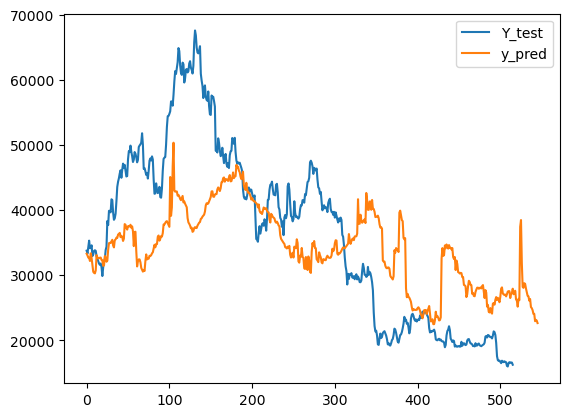

In [23]:
pd.DataFrame(zip(Y_test,y_pred),columns=['Y_test','y_pred']).plot()

In [24]:
pre_df.to_csv("../result/LSTM/btc_NN.csv")

In [25]:

!kdeconnect-cli -n TAS-AN00 --ping-msg 'Script complete!'